In [1]:
from decouple import config
from mvpa_functions import load_pickle, ados, extract, predictors_df
import os
import re
from nilearn.reporting import get_clusters_table
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
import pandas as pd
from nilearn.maskers import NiftiSpheresMasker
import nilearn.image as img 
import nilearn.plotting as nplot
from copy import deepcopy
import scipy
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

## Read in model and test images

In [2]:
img_dir = 'combined'
ml_dir = config('ml')
test_parameters = ados('G2' , test_train='test', directory=img_dir).reset_index(drop=True)
train_parameters = ados('G2', test_train='train', directory=img_dir).drop([20])
ml_models = {
    'space_net': dict(zip([re.sub('.pickle', '', key) for key in os.listdir(os.path.join(ml_dir, 'pickle', 'test_train_cv_10', img_dir))], 
                     [load_pickle(re.sub('\.pickle', '', os.path.join(os.path.join(ml_dir, 'pickle', 'test_train_cv_10', img_dir), pickle))) 
                      for pickle in os.listdir(os.path.join(ml_dir, 'pickle', 'test_train_cv_10', img_dir))])),
    'frem_svr': dict(zip([re.sub('.pickle', '', key) for key in os.listdir(os.path.join(ml_dir, 'pickle', 'test_train_cv_10', img_dir))], 
                     [load_pickle(re.sub('\.pickle', '', os.path.join(os.path.join(ml_dir, 'frem'), pickle))) 
                      for pickle in os.listdir(os.path.join(ml_dir, 'frem'))])),

}

## Calculate performance metrics

In [3]:
%%capture
test_stats =  dict(zip([key for key in ml_models.keys()], [dict(zip([domain for domain in ml_models['space_net'].keys()],
                                                                    [{} for domain in ml_models['space_net'].keys()])) for key in ml_models.keys()]))

for algo in ml_models.keys():
    for model in ml_models['space_net'].keys():
        test_stats[algo][model]['y_pred'] = ml_models[algo][model].predict(test_parameters['paths']).ravel()
        test_stats[algo][model]['r2'] = ml_models[algo][model].score(test_parameters['paths'], test_parameters[model])
        test_stats[algo][model]['mse'] = np.mean(np.abs(test_parameters[model] - test_stats[algo][model]['y_pred']))

In [4]:
for model in test_stats['space_net'].keys():
      print(f"Mean square error for {model}:\n", 
            f"space net: {test_stats['space_net'][model]['mse']},",
            f"frem svr: {test_stats['frem_svr'][model]['mse']},")
      print(f"R2 {model}:\n ", 
            f"space net: {test_stats['space_net'][model]['r2']},",
            f"frem svr: {test_stats['frem_svr'][model]['r2']},",
            "\n")

Mean square error for ADOS_com_soc:
 space net: 1.9720415936864164, frem svr: 2.1656133326600964,
R2 ADOS_com_soc:
  space net: -0.016582227975307617, frem svr: -0.10782363176153398, 

Mean square error for ADOS_Communication:
 space net: 1.523109129307058, frem svr: 1.5623489997317344,
R2 ADOS_Communication:
  space net: -0.18789761478038058, frem svr: -0.03916946289608236, 

Mean square error for ADOS_Interaction:
 space net: 0.8664021169469338, frem svr: 1.137710698727495,
R2 ADOS_Interaction:
  space net: -2.086099282990888, frem svr: -3.711509162513983, 

Mean square error for ADOS_sterotyped_and_repetititve:
 space net: 1.201012940947234, frem svr: 0.8407798918053037,
R2 ADOS_sterotyped_and_repetititve:
  space net: -0.41186762363394736, frem svr: 0.21038451305961103, 

Mean square error for ADOS_Creativity:
 space net: 0.4817565430100168, frem svr: 0.8401948649769853,
R2 ADOS_Creativity:
  space net: 0.040245018355894224, frem svr: -2.9235784523663253, 



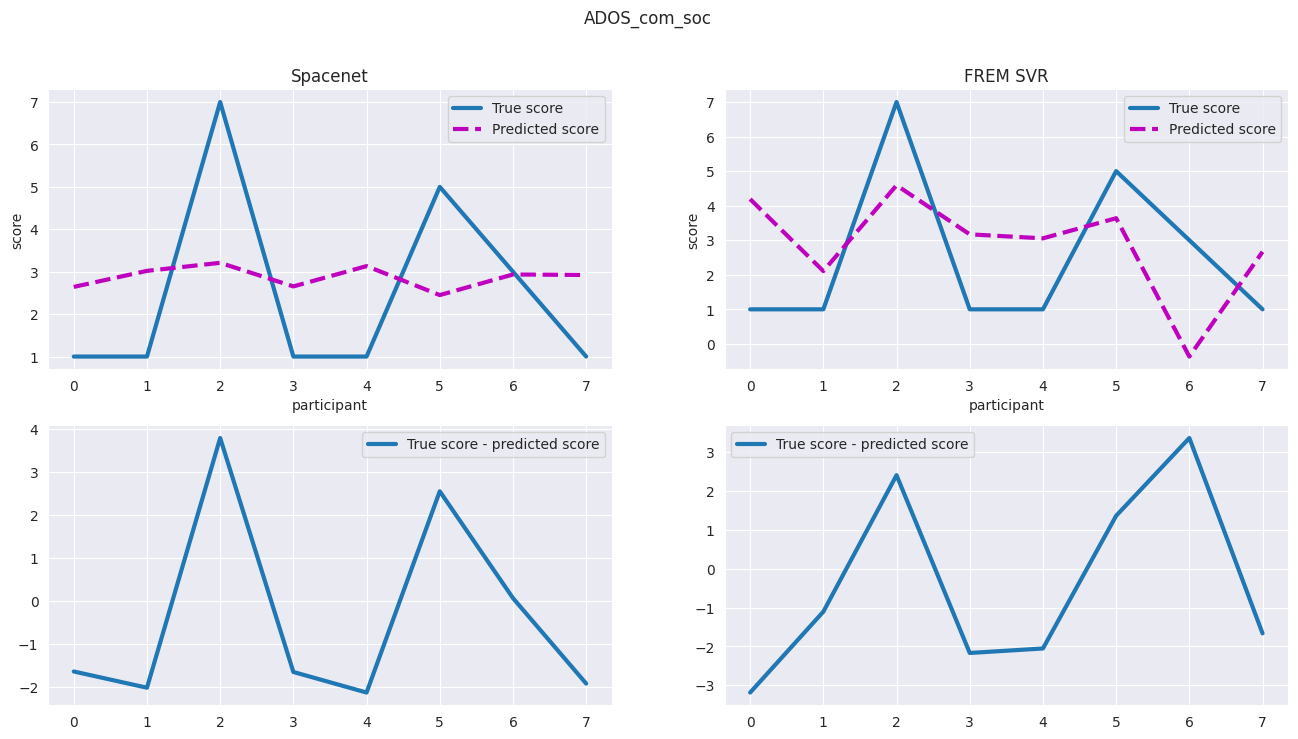

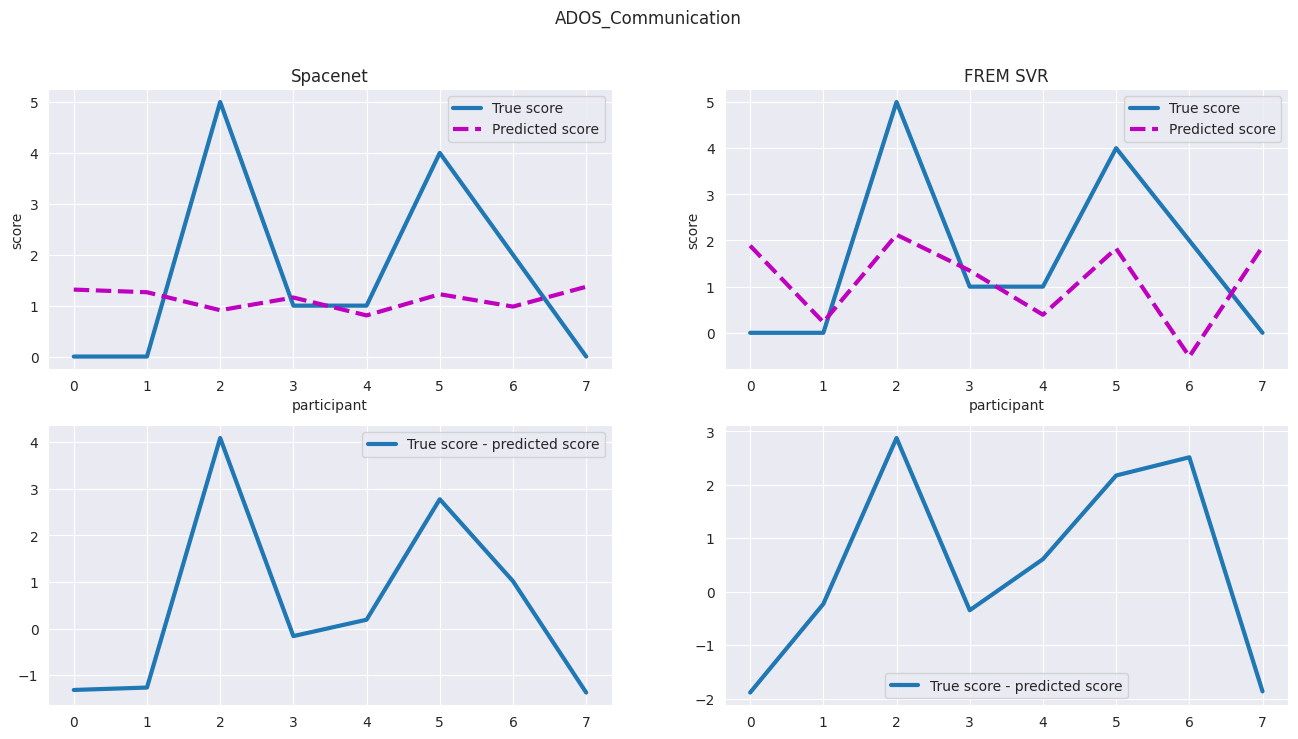

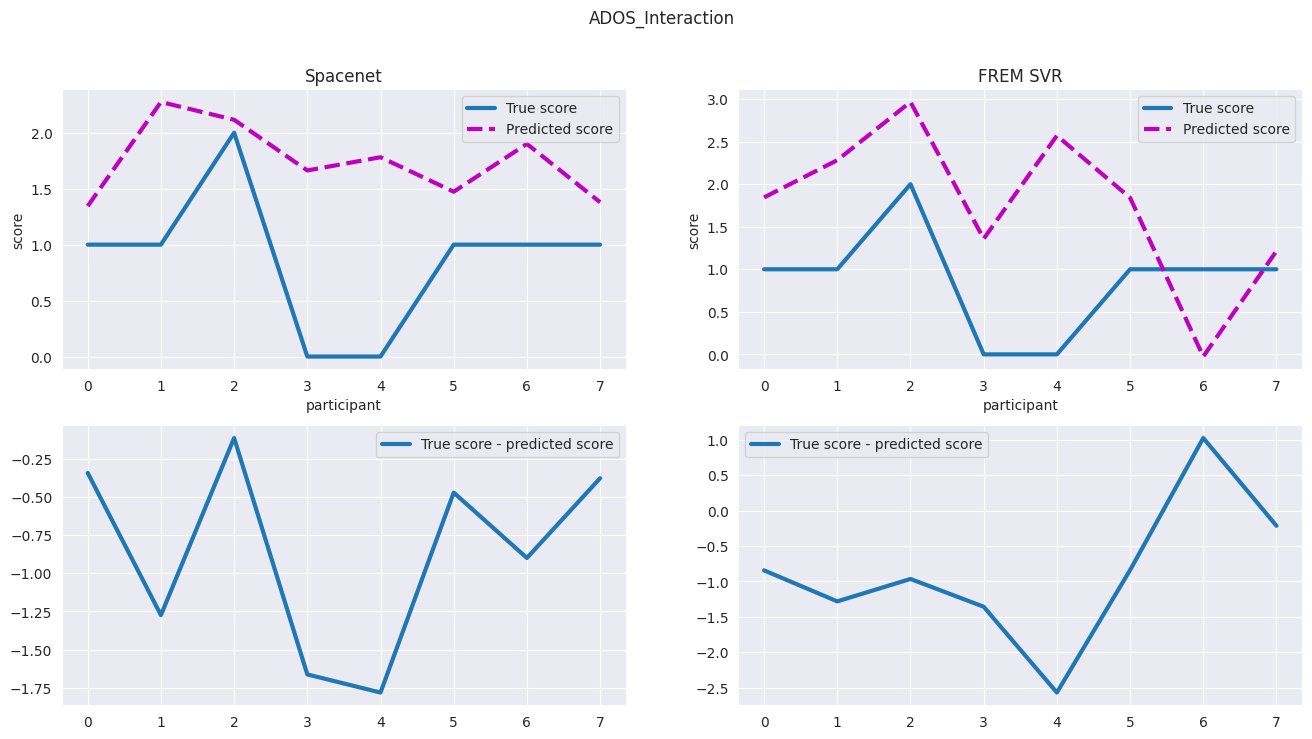

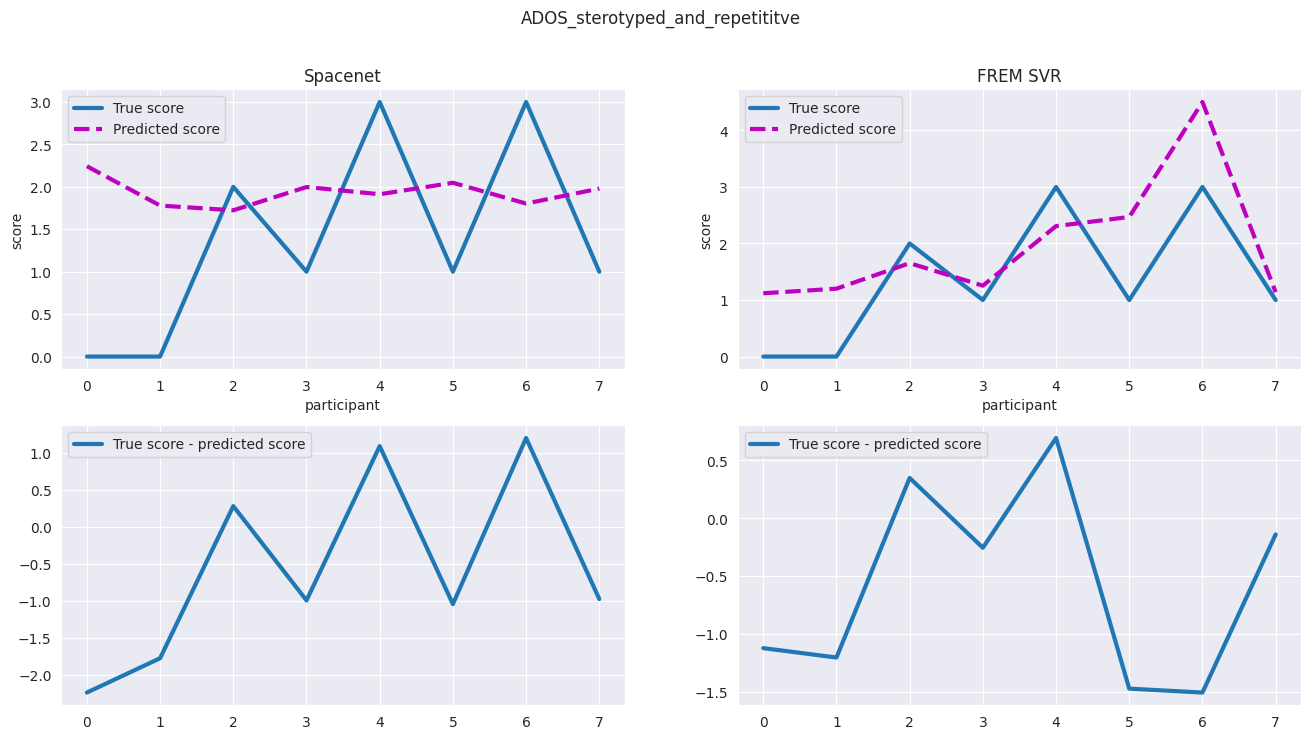

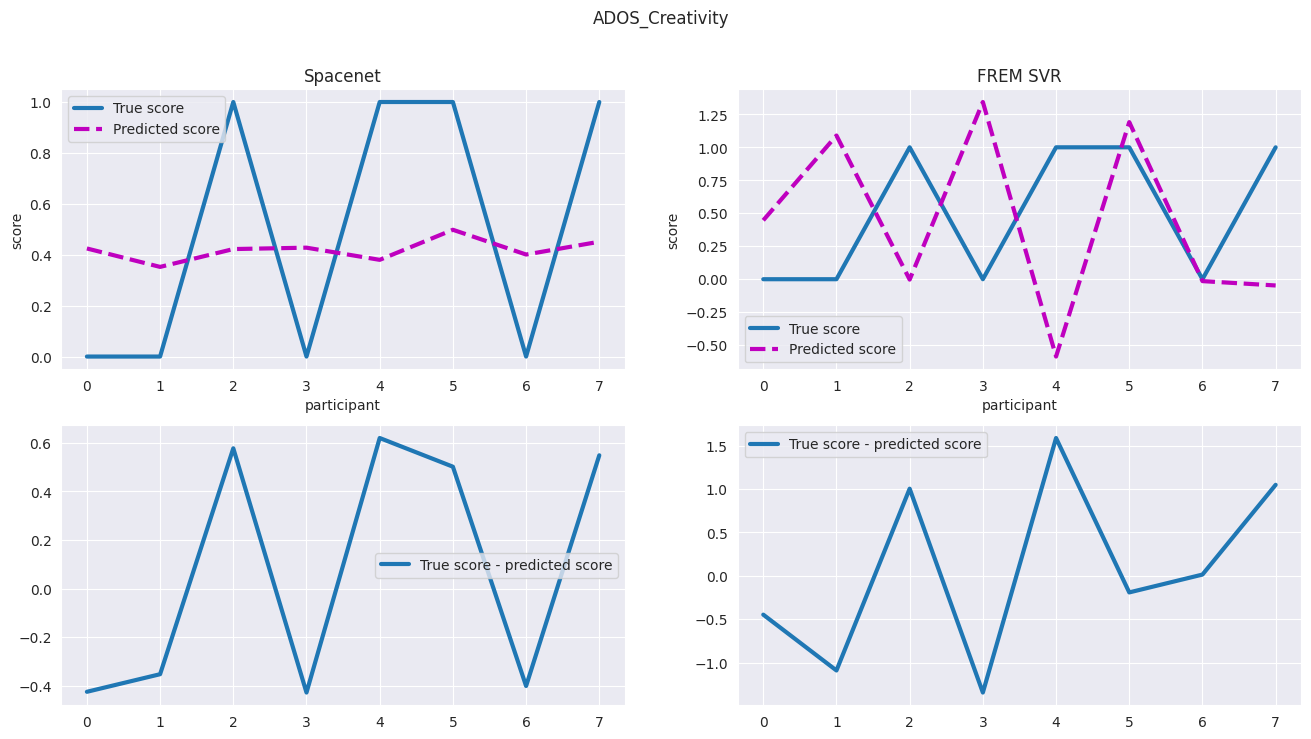

In [5]:
for model in test_stats['space_net'].keys():
    fig,ax = plt.subplots(2,2, figsize=(16,8))
    plt.suptitle(f"{model}")
    ax[0][0].plot(test_parameters[model], label="True score", linewidth=3)
    ax[0][1].plot(test_parameters[model], label="True score", linewidth=3)
    ax[0][0].plot(test_stats['space_net'][model]['y_pred'], "--", c="m", label="Predicted score", linewidth=3)
    ax[0][1].plot(test_stats['frem_svr'][model]['y_pred'], "--", c="m", label="Predicted score", linewidth=3)
    ax[0][0].set_ylabel("score")
    ax[0][1].set_ylabel("score")
    ax[0][0].set_xlabel("participant")
    ax[0][1].set_xlabel("participant")
    ax[0][0].set_title('Spacenet')
    ax[0][1].set_title('FREM SVR')
    ax[0][0].legend(loc="best")
    ax[0][1].legend(loc="best")
    ax[1][0].plot(test_parameters[model] - test_stats['space_net'][model]['y_pred'], label="True score - predicted score", linewidth=3)
    ax[1][1].plot(test_parameters[model] - test_stats['frem_svr'][model]['y_pred'], label="True score - predicted score", linewidth=3)
    ax[1][0].legend(loc="best")
    ax[1][1].legend(loc="best")

## Plot weights for models with non-negative Rsquared

In [6]:
r2_models = {}
for algo in test_stats.keys():
    for model in test_stats['space_net'].keys():
        if test_stats[algo][model]['r2'] > 0:
            r2_models[f'{algo}_{model}'] = ml_models[algo][model]

/home/k1812017/envs/neuroimaging/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


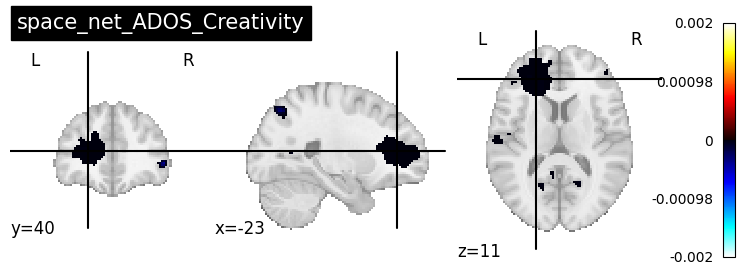

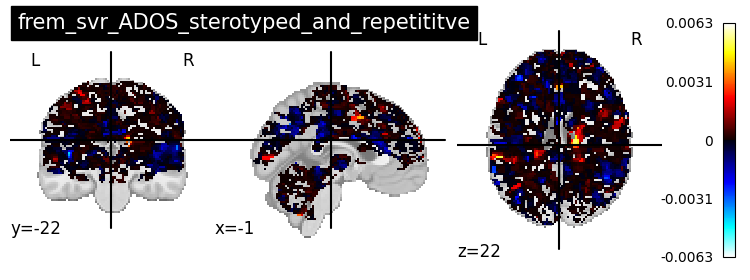

In [7]:
for model in r2_models.keys():
    img_r2 = r2_models[model].coef_img_
    if 'frem' in model:
        img_r2 = r2_models[model].coef_img_['beta']
    nplot.plot_stat_map(
        img_r2,
        title=model,
    )

## Examine Weights and weight distribution

In [8]:
frem_img = deepcopy(r2_models['frem_svr_ADOS_sterotyped_and_repetititve'].coef_img_['beta'])
space_img = deepcopy(r2_models['space_net_ADOS_Creativity'].coef_img_)
frem_betas = pd.Series(frem_img.get_fdata().ravel()).describe()
space_betas = pd.Series(space_img.get_fdata().ravel()).describe()
display('FREM ADOS_sterotyped_and_repetititve',frem_betas)
display('SPACE NET ADOS_Creativity',space_betas)

'FREM ADOS_sterotyped_and_repetititve'

count    1.082035e+06
mean    -1.623004e-07
std      2.021989e-04
min     -6.271119e-03
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.334730e-03
dtype: float64

'SPACE NET ADOS_Creativity'

count    1.082035e+06
mean    -2.828230e-07
std      1.121013e-05
min     -1.955849e-03
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      7.801038e-06
dtype: float64

## Examine which weights are significant predictors

### For Spacenet model

In [9]:
t_score_spacenet = r2_models['space_net_ADOS_Creativity'].Xmean_ / r2_models['space_net_ADOS_Creativity'].Xstd_
p_value = scipy.stats.t.sf(np.abs(t_score_spacenet), df=163653-1 )*2
if p_value[p_value<0.05].size == 0:
    print('No significant predictors')

No significant predictors


### For FREM Model

In [10]:
t_score_img_frem = img.math_img("img_1/img_2",
    img_1=r2_models['frem_svr_ADOS_sterotyped_and_repetititve'].coef_img_['beta'],
    img_2 = r2_models['frem_svr_ADOS_sterotyped_and_repetititve'].std_coef_img_['beta'])
p_value_img_frem = deepcopy(t_score_img_frem)
p_value_data = p_value_img_frem.get_fdata()
p_value_data
array_pvalues = scipy.stats.t.sf(np.abs(p_value_data), df=1082035-1)*2
pval_img= img.new_img_like(p_value_img_frem, array_pvalues)
neg_log_10 = img.math_img("-np.log10(pval)", pval=pval_img)

<string>:1: RuntimeWarning: invalid value encountered in divide


#### plot T scores and p values

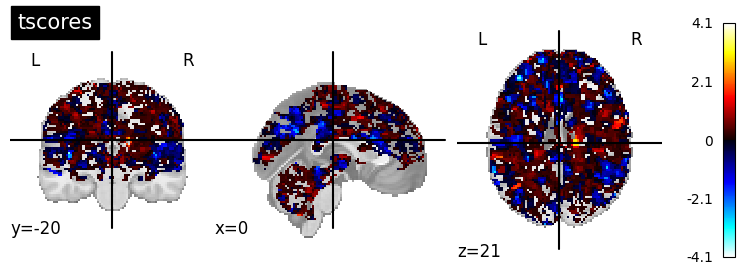

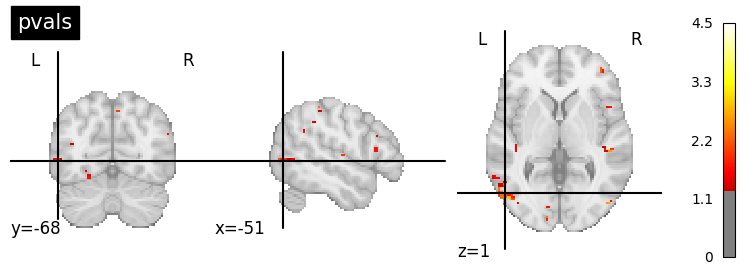

In [11]:
nplot.plot_stat_map(t_score_img_frem, title='tscores')
nplot.plot_stat_map(neg_log_10, threshold=-np.log10(0.05), title='pvals')

#### Extract regions that are signficant predictors

In [187]:
frem_predictors = get_clusters_table(neg_log_10, stat_threshold=-np.log10(0.05))
frem_predictors['pval'] = 10 ** -frem_predictors['Peak Stat'].values
coords = frem_predictors[['X', 'Y', 'Z']]
beta_t = extract(coords, r2_models['frem_svr_ADOS_sterotyped_and_repetititve'].coef_img_['beta'], t_score_img_frem)
frem_predictors_df = pd.concat((frem_predictors, beta_t), axis=1).drop('Peak Stat', axis=1)
frem_predictors_df = predictors_df(frem_predictors_df, frem_predictors_df[['X', 'Y', 'Z']])

#### See if differences found from second level are significant predictors 

In [13]:
for task in ['happy', 'eft', 'fear']:
    try: 
        cluster_df = pd.read_csv(os.path.join(config(task), '2ndlevel', 'interaction_clusters.csv'))
    except Exception:
        cluster_df = pd.read_csv(os.path.join(config(task), '2ndlevel', 'time_clusters.csv'))
    coords = cluster_df[['peak_x', 'peak_y', 'peak_z']]
    betas_df = extract(coords, r2_models['frem_svr_ADOS_sterotyped_and_repetititve'].coef_img_['beta'], t_score_img_frem )
    pval = NiftiSpheresMasker((coords.values)).fit_transform(pval_img)
    betas_df['pval'] = pd.Series(pval.ravel())
    display_df = cluster_df[['harvard_oxford']]
    if task == 'happy':
        display_df = cluster_df[['aal']]
    display(task, pd.concat((display_df, betas_df), axis=1))

'happy'

,aal,beta,t_score,pval
0,75.00% Vermis_4_5; 25.00% Cerebelum_4_5_L,0.000047,0.185695,0.852684


'eft'

,harvard_oxford,beta,t_score,pval
0,72.73% Right_Frontal_Operculum_Cortex; 27.27% ...,-0.000016,-0.019791,0.984210
1,100.00% Right_Frontal_Pole,0.000000,0.000000,0.000000
2,100.00% Right_Planum_Temporale,0.000055,0.185695,0.852684
3,100.00% Right_Putamen,0.000081,0.198860,0.842372
4,100.00% Left_Precentral_Gyrus,-0.000057,-0.185695,0.852684
5,100.00% Left_Precentral_Gyrus,0.000000,0.000000,0.000000


'fear'

,harvard_oxford,beta,t_score,pval
0,40.37% Left_Frontal_Pole; 13.30% no_label; 10....,-0.000038,-0.093389,0.925595
